# Lab CMBLenses

## Model

In [1]:
using CMBLensing, CMBLensingInferenceTestProblem
using CUDA, LaTeXStrings, MCMCDiagnosticTools, Plots, ProgressMeter, Random, Zygote
using LinearAlgebra, Statistics
ENV["LINES"] = 10;

In [2]:
using Revise
using MicroCanonicalHMC

[ Info: Precompiling MicroCanonicalHMC [234d2aa0-2291-45f7-9047-6fa6f316b0a8]


In [3]:
prob = load_cmb_lensing_problem(storage = Array,
                                T = Float32,
                                Nside = 64);

In [4]:
target = CMBLensingTarget(prob);

In [5]:
to_vec, from_vec = CMBLensingInferenceTestProblem.to_from_vec(prob.Ωstart)

(CMBLensingInferenceTestProblem.var"#to_vec#2"(), CMBLensingInferenceTestProblem.var"#from_vec#3"{Field-(f°,ϕ°,θ)-Tuple{LambertQUMap{Array{Float32, 3}}, LambertMap{Array{Float32, 2}}, ComponentArrays.ComponentVector{Float32, Vector{Float32}, Tuple{ComponentArrays.Axis{(r = 1, Aϕ = 2)}}}}}(Float32[-4.7993712, -10.132681, -13.010162, -9.098768, -3.4189508, -2.647602, -2.2184951, -1.8052056, -3.8572881, -6.549067  …  -1.4671382f-6, -1.5210153f-6, -1.5569877f-6, -1.597326f-6, -1.6578678f-6, -1.7366059f-6, -1.8154062f-6, -1.8714119f-6, -1.609438, 0.0]))

## Sample

In [6]:
grads = []
log_rs = range(-5, stop=5, length=10)
for log_r in log_rs
    Ω = prob.Ωstart
    Ω.θ.r = 10^log_r
    Ω_t = target.transform(Ω)
    grad = target.grad_nlogp(Ω_t)
    append!(grads, [target.grad_nlogp(Ω_t)])
end

grads_r = []
for grad in grads
    grad_r = grad[:][end-1]
    append!(grads_r, grad_r)
end    

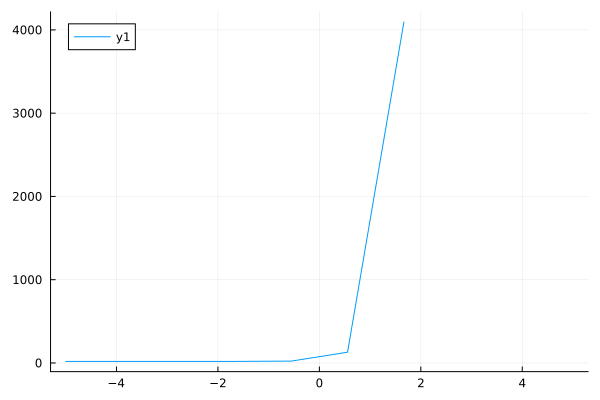

In [7]:
plot(log_rs, grads_r)

In [8]:
spl=MCHMC(10.0, 10*sqrt(50); init_L = 10*sqrt(50), init_eps=20, varE_wanted=1.0, sigma=one(LenseBasis(diag(target.Λmass))))

MicroCanonicalHMC.Sampler(Settings(MersenneTwister(0), 1.0, 0, 20, 10, "LF", 20, 70.71067811865476, nothing), Hyperparameters(10.0, 70.71067811865476, 0.0, 0.1931833275037836, Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]), MicroCanonicalHMC.Leapfrog)

In [9]:
samples = Sample(spl, target, 100; dialog=true)

[ Info: Using given sigma ✅
[ Info: Using given eps ✅
[ Info: Using given L ✅


101-element Vector{Any}:
 [-4.781805038452148, -10.115113258361816, -12.992595672607422, -9.081202507019043, -3.4013853073120117, -2.6300344467163086, -2.2009286880493164, -1.7876393795013428, -3.8397207260131836, -6.531499862670898  …  0.11428064107894897, 0.14894405007362366, 0.0817146971821785, -0.2341846525669098, -0.2612933814525604, -0.2670277953147888, NaN, 72.95442199707031, 0.0, -267087.875]
 [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, NaN, NaN, NaN, -332230.5235347662]
 [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, NaN, NaN, NaN, -332230.5235347662]
 ⋮
 [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, NaN, NaN, NaN, -332230.5235347662]
 [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, NaN, NaN, NaN, -332230.5235347662]

In [10]:
samples_redux = []
for sample in samples
    if all(isfinite.(sample))
            append!(samples_redux, [sample])
    end
end    

In [11]:
samples_redux[end][1:d]

LoadError: BoundsError: attempt to access 0-element Vector{Any} at index [0]

In [12]:
_samples = zeros(length(samples), length(samples[1]), 1)
_samples[:, :, 1] = mapreduce(permutedims, vcat, samples)
_samples = permutedims(_samples, (1,3,2))
ess, rhat = MCMCDiagnosticTools.ess_rhat(_samples)

([NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  100.08006405124098, 100.08006405124098, 100.08006405124098, 100.08006405124102, 100.08006405124102, 100.08006405124102, NaN, NaN, NaN, 100.08006405124085], [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  1.0, 0.9999999999999999, 1.0, 1.0, 0.9999999999999999, 1.0, NaN, NaN, NaN, 1.0000000000000004])

In [13]:
_ess = median(ess)

NaN

In [14]:
_rhat = median(rhat)

NaN

## Plotting

In [15]:
Plots.default(fmt=:png, dpi=120, size=(500,300), legendfontsize=10)

In [16]:
d = length(prob.Ωstart[:])

12290

In [17]:
rs = [sample[end-d-3] for sample in samples_redux]
Aϕs = [sample[end-d-2] for sample in samples_redux];

In [18]:
p_rs = [sample[end-3] for sample in samples_redux]
p_Aϕs = [sample[end-2] for sample in samples_redux];

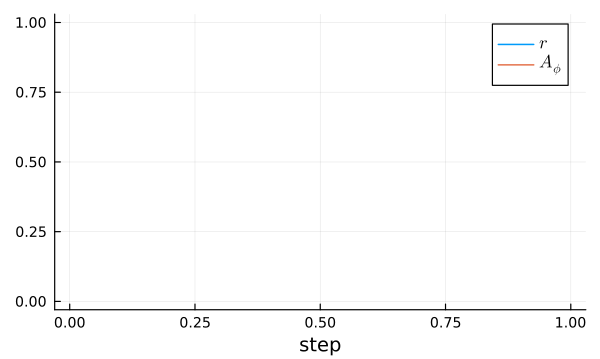

In [19]:
plot(exp.(rs), label=L"r", xlabel="step")
plot!(exp.(Aϕs), label=L"A_\phi")


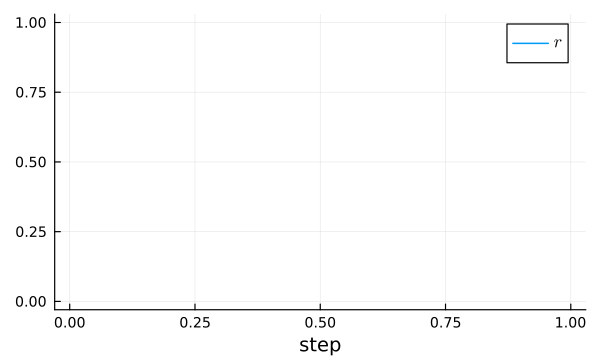

In [20]:
plot(exp.(rs), label=L"r", xlabel="step")
#plot!(exp.(Aϕs), label=L"A_\phi")


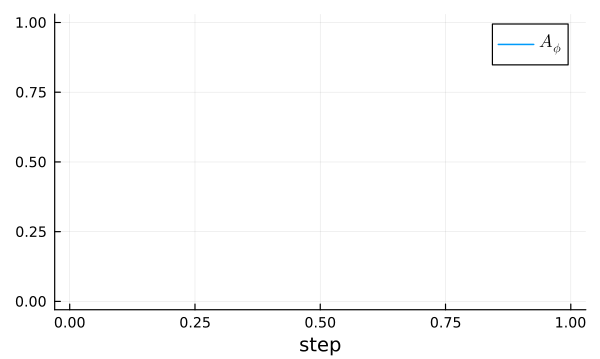

In [21]:
plot(exp.(Aϕs), label=L"A_\phi", xlabel="step")
#plot!(exp.(Aϕs), label=L"A_\phi")


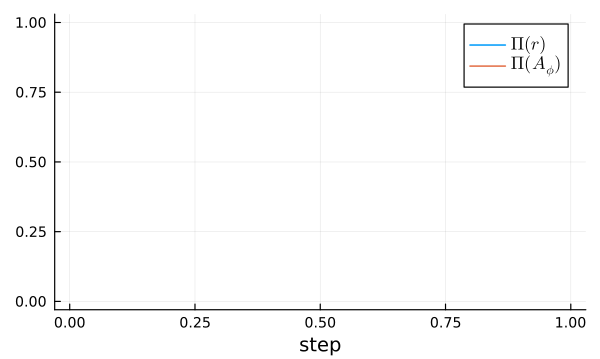

In [22]:
plot(exp.(p_rs), label=L"\Pi(r)", xlabel="step")
plot!(exp.(p_Aϕs), label=L"\Pi(A_\phi)")


In [23]:
Energy = [sample[end-1] for sample in samples];
std(Energy)^2/d

NaN

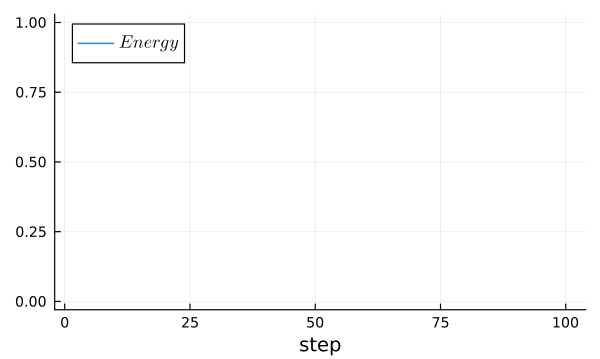

In [24]:
plot(Energy / d, label=L"Energy", xlabel="step")

In [25]:
plot(histogram(exp.(rs), xlabel=L"r", label=nothing, lw=1),
    histogram(exp.(Aϕs), xlabel=L"A_\phi", label=nothing, lw=1))

LoadError: MethodError: reducing over an empty collection is not allowed; consider supplying `init` to the reducer

In [26]:
to_vec, from_vec = CMBLensingInferenceTestProblem.to_from_vec(prob.Ωstart)
last_sample = from_vec(samples[end][1:end-2])

12290-element Field-(f°,ϕ°,θ)-Tuple{LambertQUMap{Array{Float64, 3}}, LambertMap{Array{Float64, 2}}, ComponentArrays.ComponentVector{Float32, Vector{Float32}, Tuple{ComponentArrays.Axis{(r = 1, Aϕ = 2)}}}}:
 NaN
 NaN
 NaN
   ⋮
 NaN
 NaN

In [27]:
ps = map([(:ϕ°,:I,L"L",L"\phi^\circ"), (:f°,:E,"L\ell",L"E^\circ"), (:f°,:B,L"\ell",L"B^\circ")]) do (k1, k2, xlabel, title)
    plot(get_Cℓ(prob.Ωtrue[k1][k2]); label="true", xlabel, title)
    plot!(get_Cℓ(prob.Ωstart[k1][k2]); label="start", xlabel, title)
    plot!(get_Cℓ(last_sample[k1][k2]); label="last sample", xlabel, title)
end
plot(ps..., layout=(1,3), xscale=:log10, yscale=:log10, size=(1000,300), legend=:bottomleft)

LoadError: BoundsError: attempt to access 0-element Vector{Float64} at index [1]

In [28]:
samps = [∇²*from_vec(sample[1:end-2]).ϕ°/2 for sample in samples[100:end]]
anim = @animate for i in 1:length(samps)
    motionblur = [0.5, 1, 0.5]
    frame = sum(circshift(samps, i)[1:length(motionblur)] .* motionblur) / sum(motionblur)
    plot(1 * frame, clims=(-0.5, 0.5), c=:thermal, title="κ samples")
end;

LoadError: BoundsError: attempt to access 2-element Vector{LambertFourier{Array{ComplexF64, 2}}} at index [1:3]

In [29]:
mp4(anim, "kappa_samples.mp4", fps = 25)

LoadError: UndefVarError: `anim` not defined